In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.datasets import load_iris
from xgboost import XGBClassifier

from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [34]:
train_transactions = pd.read_csv('train_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('train_identity.csv', index_col='TransactionID')

test_transactions = pd.read_csv('test_transaction.csv', index_col='TransactionID')
test_identity = pd.read_csv('test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')

In [35]:
train = train_transactions.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transactions.merge(test_identity, how='left', left_index=True, right_index=True)
test.columns = test.columns.str.replace('-', '_')

In [36]:
#print(test['id_01'])

In [37]:
print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

(590540, 433)
(506691, 432)


In [38]:
#del train, test, train_transactions, train_identity, test_transactions, test_identity

In [39]:
from sklearn import preprocessing
import xgboost as xgb

In [40]:
# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

In [44]:
iso_forest = IsolationForest(contamination=0.01)
outliers = iso_forest.fit_predict(X_train) 
X_train = X_train[outliers == 1]
y_train = y_train[outliers == 1]

In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [52]:
explained_variance_ratio = pca.explained_variance_ratio_
sorted_indices = np.argsort(explained_variance_ratio)[::-1] 
sorted_variance = explained_variance_ratio[sorted_indices]

Top 10 PCA Components and Their Most Contributing Original Features:

PC1:
  id_35: 0.0677
  V256: 0.0641
  V255: 0.0641
  V250: 0.0641
  V251: 0.0641
  V245: 0.0641
  V239: 0.0641
  V238: 0.0641
  V259: 0.0641
  V221: 0.0641

PC2:
  D13: 0.1334
  D12: 0.1306
  addr2: 0.1275
  D6: 0.1252
  addr1: 0.1241
  D14: 0.1149
  M4: 0.0991
  D7: 0.0881
  ProductCD: 0.0839
  id_02: 0.0784

PC3:
  V95: 0.1762
  V100: 0.1761
  V97: 0.1761
  V101: 0.1761
  V103: 0.1761
  V98: 0.1761
  V106: 0.1761
  V105: 0.1761
  V104: 0.1761
  V124: 0.1761

PC4:
  V279: 0.2442
  V293: 0.2437
  V290: 0.2431
  V298: 0.2386
  V284: 0.2385
  V299: 0.2383
  V287: 0.2382
  V297: 0.2380
  V286: 0.2379
  V303: 0.2378

PC5:
  V36: 0.1635
  V35: 0.1635
  V49: 0.1634
  V48: 0.1634
  V41: 0.1634
  V46: 0.1634
  V47: 0.1634
  V44: 0.1634
  V45: 0.1634
  V37: 0.1634

PC6:
  C11: 0.2972
  C1: 0.2966
  C2: 0.2961
  C6: 0.2943
  C8: 0.2890
  C10: 0.2885
  C4: 0.2873
  C7: 0.2853
  C12: 0.2853
  C14: 0.2843

PC7:
  M1: 0.1674
  V11

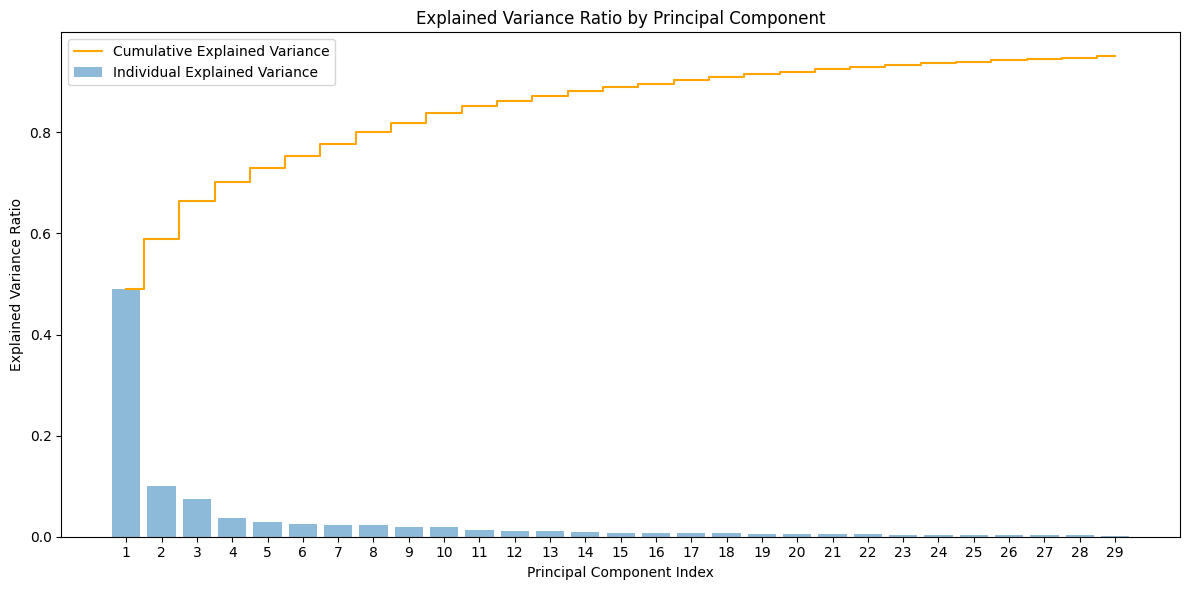

In [ ]:

pca_contributions = np.abs(pca.components_)

top_components = sorted_indices[:10] 
top_features = {}

print("Top 10 PCA Components and Their Most Contributing Original Features:")

for pc_idx in top_components:

    feature_contributions = pca_contributions[pc_idx]
    top_feature_indices = feature_contributions.argsort()[::-1][:10]  
    

    feature_names = X_train.columns[top_feature_indices]
    contributions = feature_contributions[top_feature_indices]
    

    top_features[f"PC{pc_idx+1}"] = list(zip(feature_names, contributions))

    print(f"\nPC{pc_idx+1}:")
    for feature, contribution in zip(feature_names, contributions):
        print(f"  {feature}: {contribution:.4f}")

cumulative_variance = np.cumsum(explained_variance_ratio)


plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance', color='orange')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(range(1, len(explained_variance_ratio) + 1, max(1, len(explained_variance_ratio) // 20))) 
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [47]:
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train_pca, y_train)
RF_preds = RF.predict_proba(X_test_pca)[:, 1]

In [49]:
XGB = xgb.XGBClassifier(n_estimators=100,
                        n_jobs=4,
                        max_depth=7,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        missing=-999)

XGB.fit(X_train_pca, y_train)
XGB_preds = XGB.predict_proba(X_test_pca)[:, 1]

In [51]:
stack_train = np.column_stack((
    RF.predict_proba(X_train_pca)[:, 1],
    XGB.predict_proba(X_train_pca)[:, 1]
))
stack_test = np.column_stack((RF_preds, XGB_preds))

meta_model = LogisticRegression()
meta_model.fit(stack_train, y_train)
stack_preds = meta_model.predict_proba(stack_test)[:, 1]

In [54]:
sample_submission['isFraud'] = stack_preds
sample_submission.to_csv('attempt1.csv')